In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size=15) 

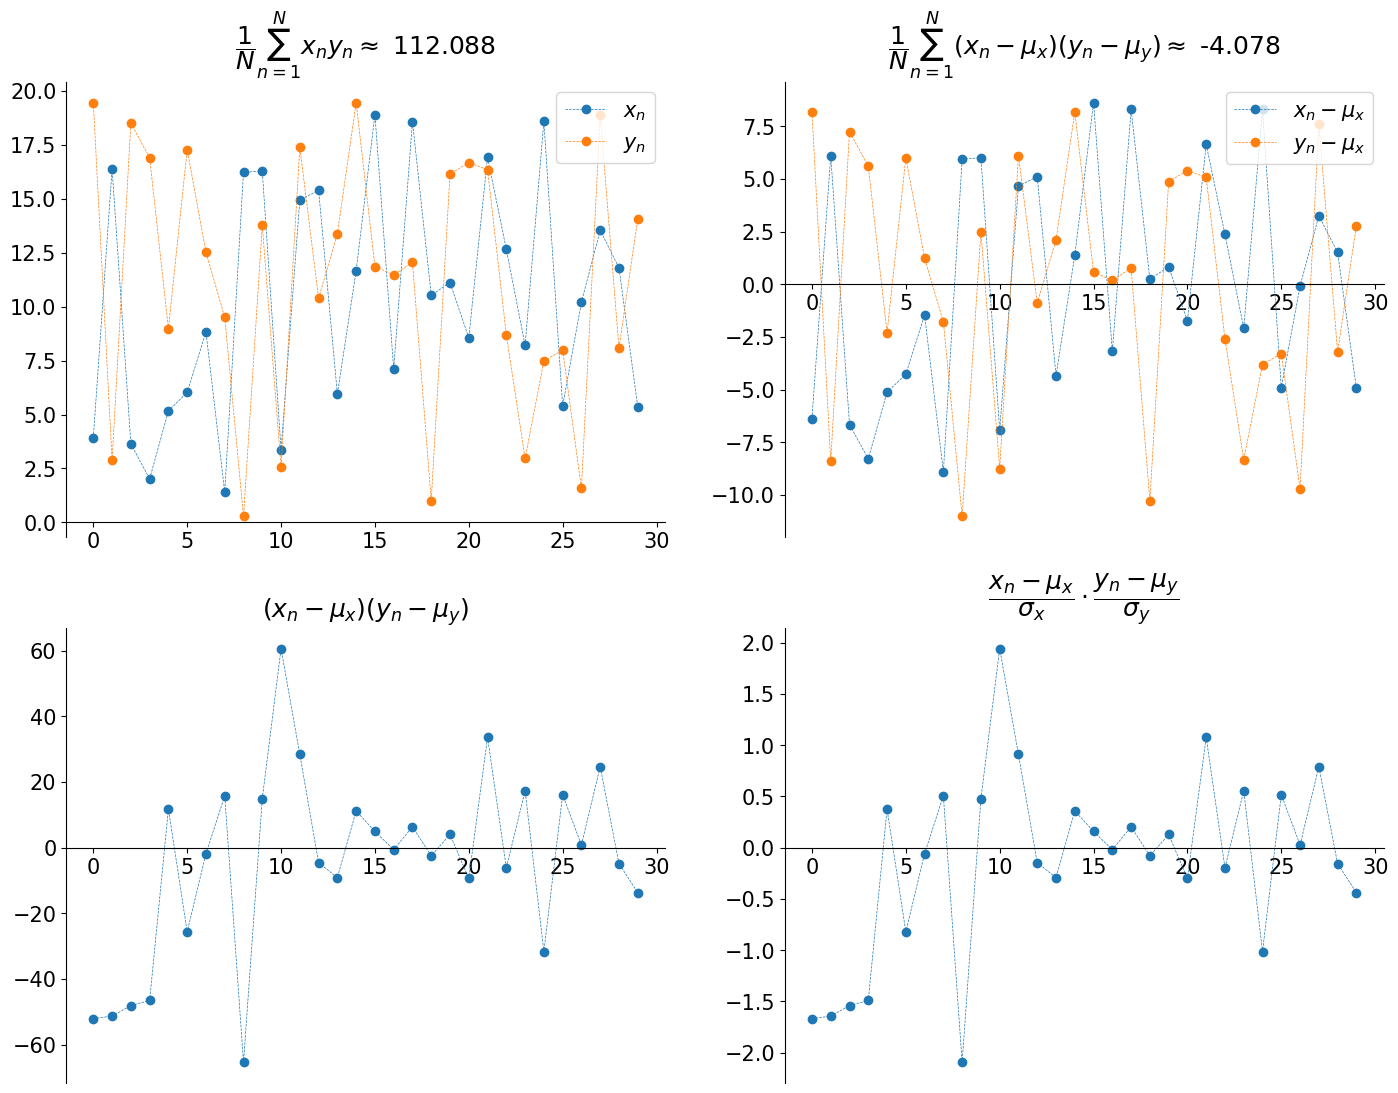

In [2]:
n_samples = 30
scale = 20

x = scale * np.random.rand(n_samples)
y = scale * np.random.rand(n_samples)

fig, axs = plt.subplots(2, 2, figsize=(17, 13))

axs[0, 0].plot(x, "o--", linewidth=0.5)
axs[0, 0].plot(y, "o--", linewidth=0.5)
axs[0, 0].set_title("$\\dfrac{1}{N} \\sum_{n=1}^N x_n y_n \\approx$ %.3f" % (np.mean(x * y)))
axs[0, 0].legend(["$x_n$", "$y_n$"], loc="upper right")


x_c = x - x.mean()
y_c = y - y.mean()
axs[0, 1].plot(x_c, "o--", linewidth=0.5)
axs[0, 1].plot(y_c, "o--", linewidth=0.5)
axs[0, 1].set_title("$\\dfrac{1}{N} \\sum_{n=1}^N (x_n - \\mu_x)( y_n - \\mu_y) \\approx$ %.3f" % (np.mean(x_c * y_c)))
axs[0, 1].legend(["$x_n - \\mu_x$", "$y_n - \\mu_x$"], loc="upper right")

axs[1, 0].plot(x_c * y_c, "o--", linewidth=0.5)
axs[1, 0].set_title("$(x_n - \mu_x)(y_n - \mu_y)$")

sigma_x = np.sqrt(np.mean(x_c**2))
sigma_y = np.sqrt(np.mean(y_c**2))
axs[1, 1].plot(x_c * y_c / sigma_x / sigma_y, "o--", linewidth=0.5)
axs[1, 1].set_title("$\\dfrac{x_n - \mu_x}{\\sigma_x} \cdot \\dfrac{y_n - \mu_y}{\\sigma_y}$")

for ax in axs.flatten().tolist():
    ax.spines['bottom'].set_position("zero")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [3]:
import pandas as pd

df = pd.read_csv("../data/galton-families.csv")
df

,Unnamed: 0,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,0,001,78.5,67.0,75.43,4,1,male,73.2
1,1,001,78.5,67.0,75.43,4,2,female,69.2
2,2,001,78.5,67.0,75.43,4,3,female,69.0
3,3,001,78.5,67.0,75.43,4,4,female,69.0
4,4,002,75.5,66.5,73.66,4,1,male,73.5
...,...,...,...,...,...,...,...,...,...
929,929,203,62.0,66.0,66.64,3,1,male,64.0
930,930,203,62.0,66.0,66.64,3,2,female,62.0
931,931,203,62.0,66.0,66.64,3,3,female,61.0
932,932,204,62.5,63.0,65.27,2,1,male,66.5


In [4]:
def corrcoeff(x, y):
    x_c = x - x.mean()
    y_c = y - y.mean()
    s_x = np.sqrt(np.mean(x_c**2))
    s_y = np.sqrt(np.mean(y_c**2))

    return np.mean(x_c * y_c) / s_x / s_y 

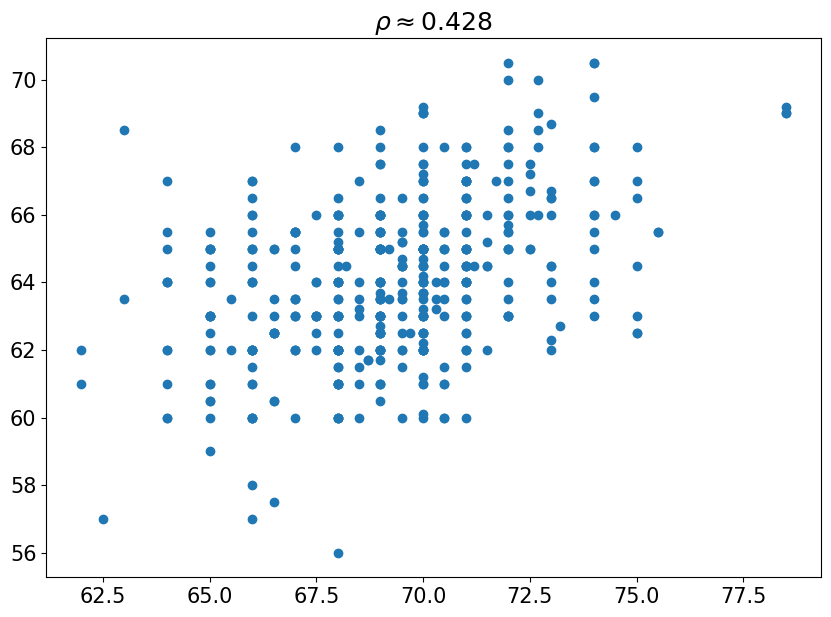

In [5]:
daughters = df[df.gender == "female"]

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(daughters.father, daughters.childHeight)
ax.set_title("$\\rho \\approx$%.3f" % (corrcoeff(daughters.father, daughters.childHeight)));

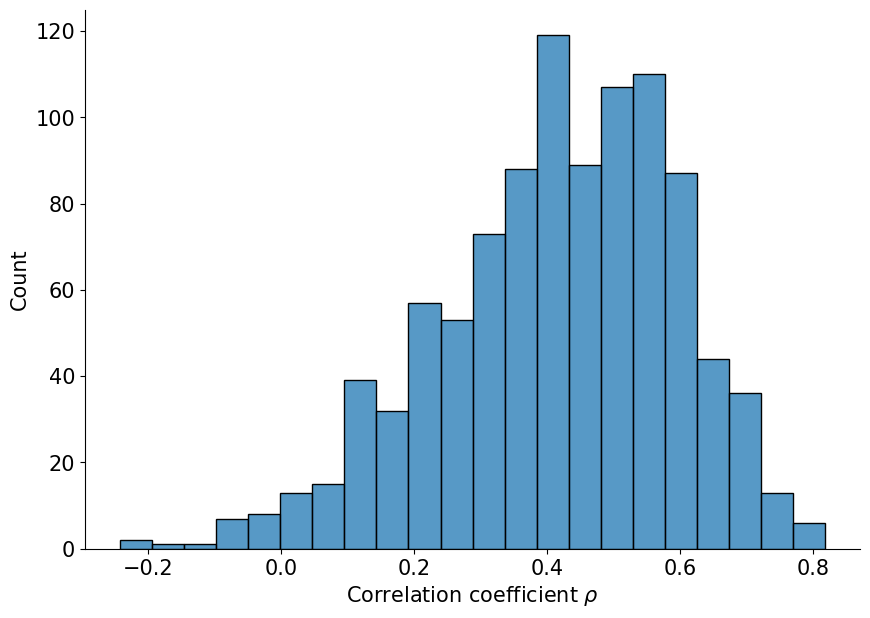

In [6]:
import random

N = 25
n_mc = 1000

daughters.reset_index()

cc = []
for i_mc in range(n_mc):
    idx = random.sample(range(len(daughters)), N)
    sample = daughters.iloc[idx]
    x = sample.father.to_numpy()
    y = sample.childHeight.to_numpy()
    cc.append(corrcoeff(x, y))

fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(cc)
ax.set_xlabel("Correlation coefficient $\\rho$")
sns.despine()


In [7]:
# it would be more principled to select 1 son per family, 
# but this is fine for illustration
sons = df[df.gender == "male"]

print("Average son height is %.1f inches (%.0f cm)" % (
    sons.childHeight.mean(),
    2.54*sons.childHeight.mean()
    )
) 

Average son height is 69.2 inches (176 cm)


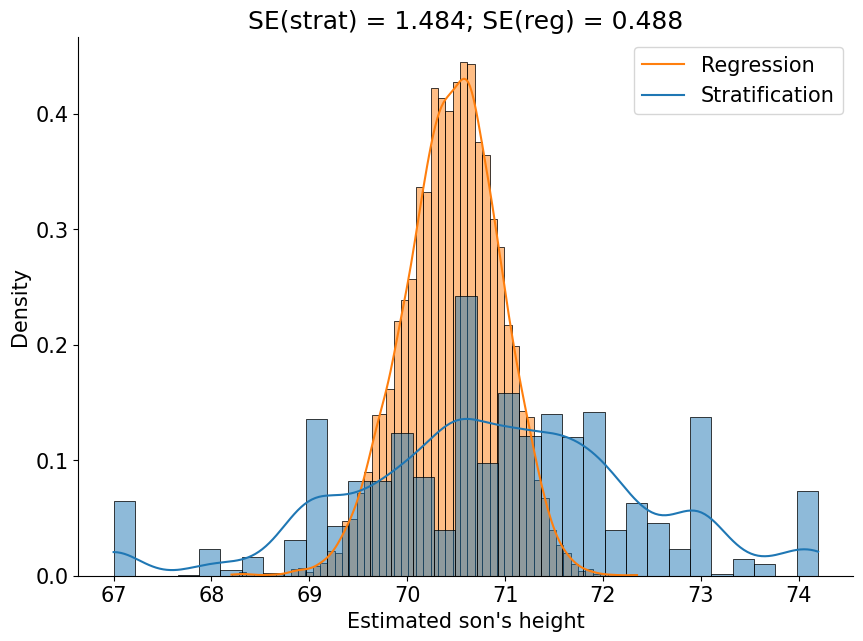

In [8]:
# comparing stratification and regression lines

n_mc = 5000
N = 50

sons.reset_index()
condmeans_72 = []
regression_72 = []
n_samples_with_72 = 0

for i_mc in range(n_mc):
    idx = random.sample(range(len(sons)), N)
    sample = sons.iloc[idx]

    fathers_72 = sample.loc[sample.father == 72]
    if len(fathers_72) != 0:
        n_samples_with_72 += 1
        condmeans_72.append(fathers_72.childHeight.mean())

    x = sample.father.to_numpy()
    y = sample.childHeight.to_numpy()
    mu_x = x.mean()
    mu_y = y.mean()
    s_x = np.sqrt(np.mean((x - mu_x)**2))
    s_y = np.sqrt(np.mean((y - mu_y)**2))
    rho = corrcoeff(x, y)
    y_hat = mu_y + rho * sigma_y * (72 - mu_x) / sigma_x
    regression_72.append(y_hat)
    

fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(
    [condmeans_72, regression_72], 
    common_bins=False, 
    stat="density", 
    kde=True
)
ax.set_xlabel("Estimated son's height")
ax.legend(["Regression", "Stratification"])
ax.set_title("SE(strat) = %.3f; SE(reg) = %.3f" % (
    np.array(condmeans_72).std(), 
    np.array(regression_72).std()
    )
)
sns.despine()

Text(0, 0.5, 'Son height')

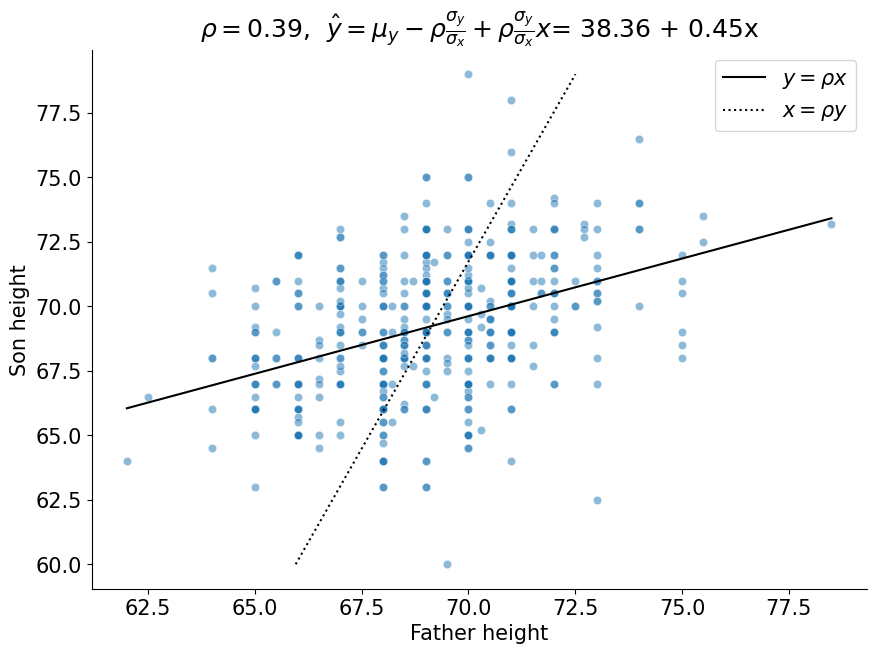

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

mu_x = sons.father.mean()
mu_y = sons.childHeight.mean()
s_x = sons.father.std()
s_y = sons.childHeight.std()
father_min = sons.father.min()
father_max = sons.father.max()
son_min = sons.childHeight.min()
son_max = sons.childHeight.max()

sns.scatterplot(
    ax=ax, 
    data=sons, 
    x="father", 
    y="childHeight", 
    alpha=0.5,
    label="_nolegend_"
)
rho = corrcoeff(sons.father, sons.childHeight)
sns.despine(ax=ax)
ax.plot(
    [
        father_min, 
        father_max
    ], 
    [
        mu_y + rho * s_y * (father_min - mu_x) / s_x, 
        mu_y + rho * s_y * (father_max - mu_x) / s_x
    ],
    'k'
)
ax.plot(
    [
        mu_x + rho * s_x * (son_min - mu_y) / s_y, 
        mu_x + rho * s_x * (son_max - mu_y) / s_y
    ], 
    [
        son_min,
        son_max
    ],
    'k:'
)
ax.set_title(
    "$\\rho =$%.2f,  " % (rho,) + \
    "$\\hat{y} = \\mu_y - \\rho \\frac{\\sigma_y}{\\sigma_x} + \\rho \\frac{\\sigma_y}{\\sigma_x} x$" + \
    "= %.2f + %.2fx" % (mu_y - rho * s_y / s_x * mu_x, rho * s_y / s_x)
)
ax.legend(["$y = \\rho x$", "$x = \\rho y$"])
ax.set_xlabel("Father height")
ax.set_ylabel("Son height")
